In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
from __future__ import division

import gym
import numpy as np
import pandas as pd
import random
import tensorflow as tf  

%load_ext tensorboard


import matplotlib.pyplot as plt
%matplotlib inline


import tensorflow_addons.layers as layers


from gym import spaces

try:
    import cPickle as pickle
except:
    import pickle


import math

try:
    xrange = xrange
except:
    xrange = range

In [3]:
#%load_ext tensorboard

In [4]:
#tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.INFO)

In [5]:
df = pd.read_csv('./osi_pca_final.csv')

In [6]:
df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,Revenue
0,0.104711,0.115576,-0.395859,-0.367811,0.792326,0.687524,-0.413624,0.404863,-0.295999,-0.032112,-0.020025,0.141937,0.128971,-0.100672,-0.406829,0.845749,0
1,0.000601,0.142662,-0.271433,-0.129434,0.178537,-0.074198,-0.258909,0.315821,-0.120330,0.054817,0.010389,0.211168,0.171537,0.018455,-0.577434,0.774437,0
2,0.110375,0.146153,-0.392492,-0.241203,0.771216,0.936403,0.567604,0.373728,-0.208422,-0.012134,-0.036700,0.155926,0.128702,0.008547,-0.345934,0.866735,0
3,0.034761,0.133210,-0.310407,-0.177025,0.365475,0.202037,-0.171265,0.328262,-0.037567,0.074858,-0.003444,0.192169,0.157149,0.051173,-0.515762,0.798940,0
4,-0.123149,0.048001,0.711157,-0.095758,0.307547,-0.108562,-0.230177,0.309132,0.017062,0.116845,0.001683,0.205523,0.176376,0.135875,-0.541553,0.803390,0


In [1]:
lamb_da = 1908/10422
class DataFrameEnv(gym.Env):
 
    def __init__(self):

        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Box(-np.inf, np.inf, shape=(16,), dtype=np.float32)

        self.viewer = None
        self.state = None

        self.steps_beyond_done = None
        self.episode = None



    def reset(self):
        episode_df= df.sample(frac=0.8)
        self.episode = episode_df.drop(columns=['Revenue']).values.tolist()
        self.true_labels = episode_df['Revenue'].values.tolist()
        
        try:
            self.state = self.episode.pop()
        except:
            self.state = None
#         self.state = self.np_random.uniform(low=-0.05, high=0.05, size=(4,))
        self.steps_beyond_done = None
        return np.array(self.state)
#     .reshape(-1,3)
    
    def step(self, action):
        assert self.action_space.contains(action), "%r (%s) invalid"%(action, type(action))
        state = self.episode.pop()
        
#     try and get the true label from list self.rewards
#     if none then done
        done = False
        true_label = self.true_labels.pop()
    
        if true_label is not None:
            if (true_label == 1) & (action == true_label):
                reward = 1
            elif (true_label == 0) & (action == true_label):
                reward = lamb_da
            elif (true_label == 0) & (action != true_label):
                reward = -lamb_da
            else:
                reward = -1
                done = True
        else:
            reward = 0
            done = True
        
        return np.array(state), reward, done, {}
    
    def validate(self):
        
        test_set = df[~df.index.isin(self.episode_df.index)]
        self.test_set_no_labels = test_set.drop(columns=['Revenue'])
        self.test_labels = test_set['Revenue']
        return self.test_set_no_labels, self.test_labels

    
env = DataFrameEnv()

NameError: name 'gym' is not defined

In [8]:
# hyperparameters
H = 64 # number of hidden layer neurons
batch_size = 4 # every how many episodes to do a param update?
learning_rate = 0.0075 # feel free to play with this to train faster or more stably.
gamma = 0.60 # discount factor for reward
learning_decay = 50 #Learning rate decay
D = 16 # input dimensionality

In [9]:
def discount_rewards(r):
    """ take 1D float array of rewards and compute discounted reward """
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(xrange(0, r.size)):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

In [10]:
# layer 1
# Batch layer
# Pooling layer
# drop out layer
# layer 11

In [11]:
tf.compat.v1.reset_default_graph()

#This defines the network as it goes from taking an observation of the environment to 
#giving a probability of chosing to the action of moving left or right.
observations = tf.compat.v1.placeholder(tf.float32, [None,D] , name="input_x")
W1 = tf.compat.v1.get_variable("W1", shape=[D, H],
           initializer=tf.initializers.GlorotUniform())
layer1 = tf.nn.tanh(tf.matmul(observations,W1))
#tf.summary.('layer1', layer1)
W11 = tf.compat.v1.get_variable("W11", shape=[H, 16],
           initializer=tf.initializers.GlorotUniform())


layer11 = tf.nn.relu(tf.matmul(layer1, W11))
#tf.summary.scalar('layer11', layer11)

W2 = tf.compat.v1.get_variable("W2", shape=[16, 1],
           initializer=tf.initializers.GlorotUniform())
score = tf.matmul(layer11,W2)

probability = tf.nn.sigmoid(score)
#tf.summary.scalar('output', probability)

#From here we define the parts of the network needed for learning a good policy.
tvars = tf.compat.v1.trainable_variables()
input_y = tf.compat.v1.placeholder(tf.float32,[None,1], name="input_y")
advantages = tf.compat.v1.placeholder(tf.float32,name="reward_signal")

# The loss function. This sends the weights in the direction of making actions 
# that gave good advantage (reward over time) more likely, and actions that didn't less likely.
loglik = tf.compat.v1.log(input_y*(input_y - probability) + (1 - input_y)*(input_y + probability))
loss = -tf.reduce_mean(loglik * advantages)


newGrads = tf.gradients(loss,tvars)
# loss_value =  tf.compat.v1.placeholder(tf.float32,name="loss_value")


# Once we have collected a series of gradients from multiple episodes, we apply them.
# We don't just apply gradeients after every episode in order to account for noise in the reward signal.
adam = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate) # Our optimizer
W1Grad = tf.compat.v1.placeholder(tf.float32,name="batch_grad1")
W11Grad = tf.compat.v1.placeholder(tf.float32,name="batch_grad11")# Placeholders to send the final gradients through when we update.
W2Grad = tf.compat.v1.placeholder(tf.float32,name="batch_grad2")
batchGrad = [W1Grad,W11Grad,W2Grad]
updateGrads = adam.apply_gradients(zip(batchGrad,tvars))

In [12]:
# # print(loglik.eval())

# init = tf.compat.v1.global_variables_initializer()
# # Launch the graph
# with tf.compat.v1.Session() as sess:
#     rendering = False
#     sess.run(init)
#     observation = env.reset() # Obtain an initial observation of the environment
# #     print(tf.compat.v1.get_variable("W11",shape=[1]))

In [13]:
xs,hs,dlogps,drs,ys,tfps = [],[],[],[],[],[]
running_reward = None
reward_sum = 0
episode_number = 1
total_episodes = 1000
episode_rewards = []
policy_gradient = []
loss_list = []

(1, 16)

In [194]:
# observation = env.reset()
# # input_layer = tf.keras.Input(shape=(1,16))
# model = tf.keras.Sequential()
# model.add(tf.keras.layers.Dense(H,activation='relu',input_shape=(1,16)))
# model.add(tf.keras.layers.Dense(8,activation='relu'))
# model.add(tf.keras.layers.Dense(1,activation='relu'))

In [203]:
model.compile(loss='binary_crossentropy', optimizer='adadelta')

In [204]:
model.build()

In [205]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 1, 32)             544       
_________________________________________________________________
dense_19 (Dense)             (None, 1, 8)              264       
_________________________________________________________________
dense_20 (Dense)             (None, 1, 1)              9         
Total params: 817
Trainable params: 817
Non-trainable params: 0
_________________________________________________________________


In [236]:
action

0

In [237]:
rendering = False
observation = env.reset() # Obtain an initial observation of the environment
x = np.reshape(observation,[1,D])
model.fit(x[:,None],np.array([[np.random.randint(low=0,high=2)]]))
action = int(model.predict(x[:,None]))
observation, reward, done, info = env.step(action)

Train on 1 samples
1/1 [==============================] - 0s 998us/sample - loss: 6.7722e-04


In [238]:
done

False

In [240]:
# model.fit(observation,np.array([[np.random.randint(low=0,high=2)]]),)


ValueError: Error when checking input: expected dense_18_input to have 3 dimensions, but got array with shape (16, 1)

In [ ]:
init = tf.compat.v1.global_variables_initializer()
# Launch the graph
with tf.compat.v1.Session() as sess:

    rendering = False
    sess.run(init)
    observation = env.reset() # Obtain an initial observation of the environment

    # Reset the gradient placeholder. We will collect gradients in 
    # gradBuffer until we are ready to update our policy network. 
    gradBuffer = sess.run(tvars)
    for ix,grad in enumerate(gradBuffer):
        gradBuffer[ix] = grad * 0
    
    while episode_number <= total_episodes:
        
        # Rendering the environment slows things down, 
        # so let's only look at it once our agent is doing a good job.
        #if reward_sum/batch_size > 100 or rendering == True : 
            #env.render()
            #rendering = True
            #print (reward_sum)
        
        # Make sure the observation is in a shape the network can handle.
        x = np.reshape(observation,[1,D])
        
        # Run the policy network and get an action to take. 
        tfprob = sess.run(probability,feed_dict={observations: x})
        action = 1 if np.random.uniform() < tfprob else 0
        #_approx.append(score)
        #         if (tfprob<0.01) & (tfprob < 0.5):
#             action = np.random.choice(np.array([0,1]))
#         else:
#             action = int(tfprob)
        
        xs.append(x) # observation
        y = 1 if action == 0 else 0 # a "fake label"
        ys.append(y)

        # step the environment and get new measurements
        observation, reward, done, info = env.step(action)
        #print(reward)
        reward_sum += reward

        drs.append(reward) # record reward (has to be done after we call step() to get reward for previous action)
        
        
        if done: 
            episode_number += 1
            # stack together all inputs, hidden states, action gradients, and rewards for this episode
            epx = np.vstack(xs)
            epy = np.vstack(ys)
            epr = np.vstack(drs)
            episode_rewards.append(np.sum(drs))
            tfp = tfps
            xs,hs,dlogps,drs,ys,tfps = [],[],[],[],[],[] # reset array memory

            # compute the discounted reward backwards through time
            discounted_epr = discount_rewards(epr)
            # size the rewards to be unit normal (helps control the gradient estimator variance)
            #discounted_epr = discounted_epr - np.mean(discounted_epr)
            #discounted_epr = discounted_epr//np.std(discounted_epr)
            
            # Get the gradient for this episode, and save it in the gradBuffer
            tGrad = sess.run(newGrads,feed_dict={observations: epx, input_y: epy, advantages: discounted_epr})
            for ix,grad in enumerate(tGrad):
                gradBuffer[ix] += grad
                
            # If we have completed enough episodes, then update the policy network with our gradients.
            if episode_number % batch_size == 0: 
                policy_gradient.append(gradBuffer)
                sess.run(updateGrads,feed_dict={W1Grad: gradBuffer[0],W11Grad:gradBuffer[1],W2Grad:gradBuffer[2]})
                ## Losses
#                 oss = sess.run(loss
                loss_list.append(loss)
                for ix,grad in enumerate(gradBuffer):
                    gradBuffer[ix] = grad * 0
                
                # Give a summary of how well our network is doing for each batch of episodes.
                running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
                #if running_reward > 70:
                print('Average reward for episode %f.  Total average reward %f.' % (reward_sum//batch_size, running_reward//batch_size))
                
                if reward_sum > 2000: 
                    print("Task solved in",episode_number,'episodes!')
                    break
                tf.compat.v1.train.LoggingTensorHook(tensors = ['loss'],every_n_iter=1)
                reward_sum = 0
#             loss_list.append(loss.eval())
            observation = env.reset()
        
            #f episode_number % 2000 == 0:
                
                #earning_rate -= 0.001 
                #rint(learning_rate)
            
print(episode_number,'Episodes completed.')


In [ ]:
init = tf.compat.v1.global_variables_initializer()
# Launch the graph
with tf.compat.v1.Session() as sess:
    sess.run(init)
    rendering = False
    
    

    # Reset the gradient placeholder. We will collect gradients in 
    # gradBuffer until we are ready to update our policy network. 
    gradBuffer = sess.run(tvars)
    for ix,grad in enumerate(gradBuffer):
        gradBuffer[ix] = grad * 0
    for n in range(10):
        observation = env.reset() # Obtain an initial observation of the environment
        episode_number = 1
        while episode_number <= total_episodes:

            # Rendering the environment slows things down, 
            # so let's only look at it once our agent is doing a good job.
            #if reward_sum/batch_size > 100 or rendering == True : 
                #env.render()
                #rendering = True
                #print (reward_sum)

            # Make sure the observation is in a shape the network can handle.
            x = np.reshape(observation,[1,D])

            # Run the policy network and get an action to take. 
            tfprob = sess.run(probability,feed_dict={observations: x})
            action = 1 if np.random.uniform() < tfprob else 0
            #_approx.append(score)
            #         if (tfprob<0.01) & (tfprob < 0.5):
    #             action = np.random.choice(np.array([0,1]))
    #         else:
    #             action = int(tfprob)

            xs.append(x) # observation
            y = 1 if action == 0 else 0 # a "fake label"
            ys.append(y)
            #print(action)
            # step the environment and get new measurements
            observation, reward, done, info = env.step(action)
            #print(reward)
            reward_sum += reward

            drs.append(reward) # record reward (has to be done after we call step() to get reward for previous action)


            if done: 
                episode_number += 1
                # stack together all inputs, hidden states, action gradients, and rewards for this episode
                epx = np.vstack(xs)
                epy = np.vstack(ys)
                epr = np.vstack(drs)
                episode_rewards.append(np.sum(drs))
                tfp = tfps
                xs,hs,dlogps,drs,ys,tfps = [],[],[],[],[],[] # reset array memory

                # compute the discounted reward backwards through time
                discounted_epr = discount_rewards(epr)
                # size the rewards to be unit normal (helps control the gradient estimator variance)
                #discounted_epr = discounted_epr - np.mean(discounted_epr)
                #discounted_epr = discounted_epr//np.std(discounted_epr)

                # Get the gradient for this episode, and save it in the gradBuffer
                tGrad = sess.run(newGrads,feed_dict={observations: epx, input_y: epy, advantages: discounted_epr})
                for ix,grad in enumerate(tGrad):
                    gradBuffer[ix] += grad

                # If we have completed enough episodes, then update the policy network with our gradients.
                if episode_number % batch_size == 0: 
                    policy_gradient.append(gradBuffer)
                    sess.run(updateGrads,feed_dict={W1Grad: gradBuffer[0],W11Grad:gradBuffer[1],W2Grad:gradBuffer[2]})
                    ## Losses
    #                 oss = sess.run(loss
                    loss_list.append(loss)
                    for ix,grad in enumerate(gradBuffer):
                        gradBuffer[ix] = grad * 0

                    # Give a summary of how well our network is doing for each batch of episodes.
                    running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
                    #if running_reward > 70:
                    print('Average reward for episode %f.  Total average reward %f.' % (reward_sum//batch_size, running_reward//batch_size))

                    if reward_sum > 2000: 
                        print("Task solved in",episode_number,'episodes!')
                        break
                    #tf.compat.v1.train.LoggingTensorHook(tensors = ['loss'],every_n_iter=1)
                    reward_sum = 0
    #             loss_list.append(loss.eval())
        observation = env.reset()
    test_set, test_labels = env.validate()
    
    for i in test_set.values:
        
        prediction = sess.run(probability, feed_dict={observations:np.reshape(i,[1,D])})
        predictions.append(prediction)
                #f episode_number % 2000 == 0:

                    #earning_rate -= 0.001 
                    #rint(learning_rate)
        #tf.compat.v1.Session()
        print(episode_number,'Episodes completed.')


Average reward for episode -1.000000.  Total average reward -1.000000.
Average reward for episode 0.000000.  Total average reward -1.000000.
Average reward for episode -1.000000.  Total average reward -1.000000.
Average reward for episode -1.000000.  Total average reward -1.000000.
Average reward for episode -1.000000.  Total average reward -1.000000.
Average reward for episode -1.000000.  Total average reward -1.000000.
Average reward for episode 0.000000.  Total average reward -1.000000.
Average reward for episode 0.000000.  Total average reward -1.000000.
Average reward for episode 0.000000.  Total average reward -1.000000.
Average reward for episode -1.000000.  Total average reward -1.000000.
Average reward for episode 0.000000.  Total average reward -1.000000.
Average reward for episode -1.000000.  Total average reward -1.000000.
Average reward for episode 0.000000.  Total average reward -1.000000.
Average reward for episode -1.000000.  Total average reward -1.000000.
Average rewa

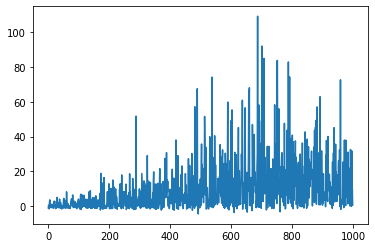

In [279]:
plt.plot(episode_rewards)

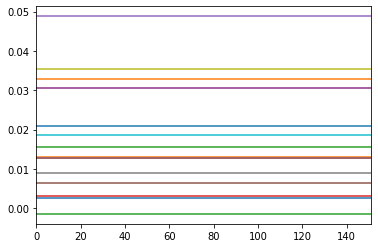

In [258]:
pd.DataFrame(np.hstack([update for update in output_layer_list])).T.plot(legend=False)

In [259]:
pd.DataFrame(np.hstack([update for update in output_layer_list]))

,0,1,2,3,4,5,6,7,8,9,...,142,143,144,145,146,147,148,149,150,151
0,0.002613,0.002613,0.002613,0.002613,0.002613,0.002613,0.002613,0.002613,0.002613,0.002613,...,0.002613,0.002613,0.002613,0.002613,0.002613,0.002613,0.002613,0.002613,0.002613,0.002613
1,0.013073,0.013073,0.013073,0.013073,0.013073,0.013073,0.013073,0.013073,0.013073,0.013073,...,0.013073,0.013073,0.013073,0.013073,0.013073,0.013073,0.013073,0.013073,0.013073,0.013073
2,-0.001405,-0.001405,-0.001405,-0.001405,-0.001405,-0.001405,-0.001405,-0.001405,-0.001405,-0.001405,...,-0.001405,-0.001405,-0.001405,-0.001405,-0.001405,-0.001405,-0.001405,-0.001405,-0.001405,-0.001405
3,0.003123,0.003123,0.003123,0.003123,0.003123,0.003123,0.003123,0.003123,0.003123,0.003123,...,0.003123,0.003123,0.003123,0.003123,0.003123,0.003123,0.003123,0.003123,0.003123,0.003123
4,0.048805,0.048805,0.048805,0.048805,0.048805,0.048805,0.048805,0.048805,0.048805,0.048805,...,0.048805,0.048805,0.048805,0.048805,0.048805,0.048805,0.048805,0.048805,0.048805,0.048805
5,0.006470,0.006470,0.006470,0.006470,0.006470,0.006470,0.006470,0.006470,0.006470,0.006470,...,0.006470,0.006470,0.006470,0.006470,0.006470,0.006470,0.006470,0.006470,0.006470,0.006470
6,0.012803,0.012803,0.012803,0.012803,0.012803,0.012803,0.012803,0.012803,0.012803,0.012803,...,0.012803,0.012803,0.012803,0.012803,0.012803,0.012803,0.012803,0.012803,0.012803,0.012803
7,0.009073,0.009073,0.009073,0.009073,0.009073,0.009073,0.009073,0.009073,0.009073,0.009073,...,0.009073,0.009073,0.009073,0.009073,0.009073,0.009073,0.009073,0.009073,0.009073,0.009073
8,0.035432,0.035432,0.035432,0.035432,0.035432,0.035432,0.035432,0.035432,0.035432,0.035432,...,0.035432,0.035432,0.035432,0.035432,0.035432,0.035432,0.035432,0.035432,0.035432,0.035432
9,0.018746,0.018746,0.018746,0.018746,0.018746,0.018746,0.018746,0.018746,0.018746,0.018746,...,0.018746,0.018746,0.018746,0.018746,0.018746,0.018746,0.018746,0.018746,0.018746,0.018746


In [249]:
len(policy_gradient)

152

In [251]:
output_layer_list = []

In [252]:
for i in policy_gradient:
    #plt.figure(figsize=(12,8))
    output_layer_list.append(i[-1])
    #plt.plot(i[-2])
    #plt.plot(i[-3])

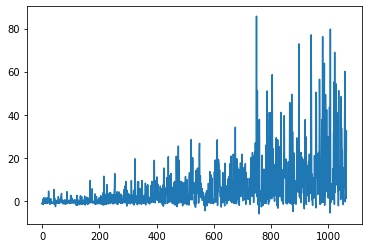

In [261]:
plt.plot(episode_rewards)

ValueError: setting an array element with a sequence.

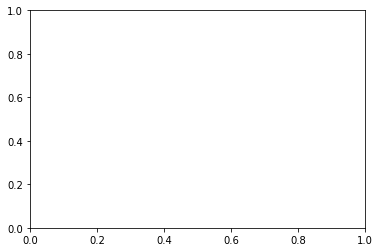

In [67]:
plt.plot(policy_gradient[0])

In [70]:
# tf.reset_default_graph()




# #These lines establish the feed-forward part of the network used to choose actions
# inputs1 = tf.placeholder(shape=[1,16],dtype=tf.float32)
# W = tf.Variable(tf.random_uniform([16,4],0,0.01))
# Qout = tf.matmul(inputs1,W)
# predict = tf.argmax(Qout,1)

# #Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
# nextQ = tf.placeholder(shape=[1,4],dtype=tf.float32)
# loss = tf.reduce_sum(tf.square(nextQ - Qout))
# trainer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
# updateModel = trainer.minimize(loss)

# init = tf.global_variables_initializer()

# # Set learning parameters
# y = .99
# e = 0.1
# num_episodes = 2000
# #create lists to contain total rewards and steps per episode
# jList = []
# rList = []
# with tf.Session() as sess:
#     sess.run(init)
#     for i in range(num_episodes):
#         #Reset environment and get first new observation
#         s = env.reset()
#         rAll = 0
#         d = False
#         j = 0
#         #The Q-Network
#         while j < 99:
#             j+=1
#             #Choose an action by greedily (with e chance of random action) from the Q-network
#             a,allQ = sess.run([predict,Qout],feed_dict={inputs1:np.identity(16)[s:s+1]})
#             if np.random.rand(1) < e:
#                 a[0] = env.action_space.sample()
#             #Get new state and reward from environment
#             s1,r,d,_ = env.step(a[0])
#             #Obtain the Q' values by feeding the new state through our network
#             Q1 = sess.run(Qout,feed_dict={inputs1:np.identity(16)[s1:s1+1]})
#             #Obtain maxQ' and set our target value for chosen action.
#             maxQ1 = np.max(Q1)
#             targetQ = allQ
#             targetQ[0,a[0]] = r + y*maxQ1
#             #Train our network using target and predicted Q values
#             _,W1 = sess.run([updateModel,W],feed_dict={inputs1:np.identity(16)[s:s+1],nextQ:targetQ})
#             rAll += r
#             s = s1
#             if d == True:
#                 #Reduce chance of random action as we train the model.
#                 e = 1./((i/50) + 10)
#                 break
#         jList.append(j)
#         rList.append(rAll)
# print("Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%")
